# External Strategy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

import multiprocessing as mp
from multiprocessing import get_context

from ebc.sequential.non_iterative import SensitivityBasedIS
from ebc.sequential.iterative_with_convexification import SensitivityBasedFW
from ebc.sequential.iterative_no_convexification import SparseVI, GIGA, IHT
from ebc.parallel.parallel_iterative_with_convexification import ParallelSensitivityBasedFW
from ebc.gaussian import fisher_norm_under_true_gaussian_posterior, gaussian_multivariate_log_likelihood, gaussian_KL


Bad key text.latex.preview in file /opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

In [3]:
def distribute_based_on_sensitivities(sensitivities):
    
    sens = sensitivities.copy()
    
    N = sens.shape[0]
    
    # Calculate probabilities for distribution for each data point
    full_inds = []
    chunk_size = N // (mp.cpu_count() - 2)
    
    for i in range(mp.cpu_count() - 2):
        inds = np.random.choice(np.arange(N), chunk_size, replace = False, p = sens.flatten() / np.sum(sens))
        sens[inds] = 0
        full_inds.append(inds.flatten().tolist())

    full_inds.append(np.arange(N)[sens.flatten() != 0].tolist())
    
    return full_inds

In [4]:
def apply_algorithm(alg, 
                    x = None, 
                    k = None,
                    norm = None,
                    na = None,
                    likelihood_gram_matrix = None):
    inst = alg(x)
    w, I = inst.run(k = k, likelihood_gram_matrix = likelihood_gram_matrix, norm = norm, norm_attributes = na)
    return w

In [5]:
def external_parallelization(alg, x, k, norm, na, distributed_indices, likelihood_gram_matrix):
    pool = get_context("fork").Pool(mp.cpu_count() - 1)
    
    if likelihood_gram_matrix is None:
        output = [pool.apply(apply_algorithm, args = [alg, 
                                                      x[ind, :],
                                                      k, 
                                                      norm, 
                                                      na,
                                                      None]) for ind in distributed_indices]
    else:
        output = [pool.apply(apply_algorithm, args = [alg, 
                                                      x[ind, :],
                                                      k, 
                                                      norm, 
                                                      na,
                                                      likelihood_gram_matrix[np.ix_(ind, ind)]]) for ind in distributed_indices]
    
    
    pool.close()
    w = np.concatenate(output)
    
    return w

## Mean of multivariate Gaussian

In [6]:
def log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return np.diag(gaussian_multivariate_log_likelihood(X.T, mu, sigma)).reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return (-np.linalg.inv(sigma) @ (X.T - mu)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [7]:
# Generate Data
d = 20
N = 10000

np.random.seed(123)

# Theta as in sparse_vi
theta = np.random.multivariate_normal(mean = np.zeros(d), cov = np.identity(d))

# x as in sparse_vi
x = np.random.multivariate_normal(mean = theta, cov = np.identity(d), size = N)

# Parameters
sigma_0 = np.identity(d)
sigma = np.identity(d)
mu_0 = np.zeros(d).reshape(-1, 1)

# Full Gaussian posterior
sigma_full = np.linalg.inv(np.linalg.inv(sigma_0) + N * np.linalg.inv(sigma))
mu_full =  sigma_full @ (np.linalg.inv(sigma_0) @ mu_0 + np.linalg.inv(sigma) @ np.sum(x, axis = 0).reshape(-1, 1))        

na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 500,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 500,
      "log_posterior": log_posterior,
      "log_posterior_start_value": np.ones(2 * d)}

## 1.1. Precomputed Likelihood Matrix 

In [7]:
from ebc.approximations import random_kitchen_sinks
start = time.time()
v = random_kitchen_sinks(x, None, 1, "Laplace", log_likelihood, 
                     np.ones(2 * d), 1000, norm = "2", MCMC_subs_size = 500)

likelihood_gram_matrix = v @ v.T

estim_time = time.time() - start
print(estim_time)

875.0596890449524


In [9]:
coreset_sizes = np.arange(100, 2600, 500)

In [9]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

for i in coreset_sizes:
    
    ## Parallel
    
    start = time.time()
    # Step 1: distribute
    sens = np.sqrt(np.diag(likelihood_gram_matrix))
    full_inds = distribute_based_on_sensitivities(sens.copy())
    
    # Step 2: run
    w = external_parallelization(SensitivityBasedFW, x, int(i // mp.cpu_count()), "2", 
                                 na, full_inds, likelihood_gram_matrix)
    time_p.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    sbfw = SensitivityBasedFW(x)
    w, I = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

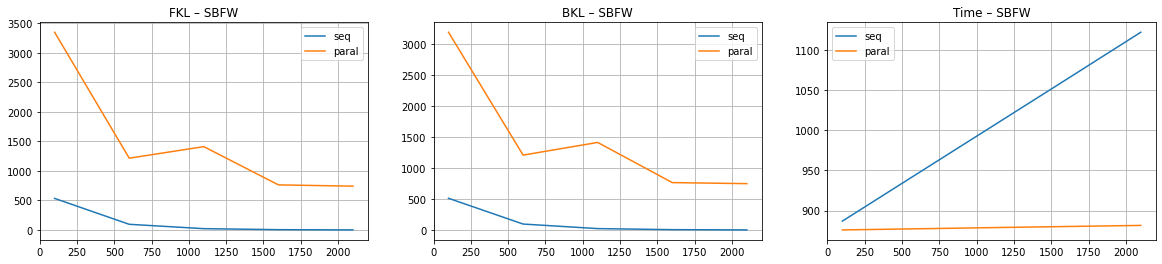

In [10]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))
ax[0].plot(coreset_sizes, fkl_s, label = 'seq')
ax[0].plot(coreset_sizes, fkl_p, label = 'paral')
ax[0].set_title('FKL – SBFW')
ax[0].grid()
ax[0].legend()

ax[1].plot(coreset_sizes, bkl_s, label = 'seq')
ax[1].plot(coreset_sizes, bkl_p, label = 'paral')
ax[1].set_title('BKL – SBFW')
ax[1].grid()
ax[1].legend()

ax[2].plot(coreset_sizes, time_s, label = 'seq')
ax[2].plot(coreset_sizes, time_p, label = 'paral')
ax[2].set_title('Time – SBFW')
ax[2].grid()
ax[2].legend()

## 1.2. Recalculated Local Likelihood Matrix 

In [7]:
from ebc.approximations import random_kitchen_sinks
start = time.time()
v = random_kitchen_sinks(x, None, 1, "Laplace", log_likelihood, 
                     np.ones(2 * d), 1000, norm = "2", MCMC_subs_size = 500)

likelihood_gram_matrix = v @ v.T

estim_time = time.time() - start
print(estim_time)


KeyboardInterrupt



In [10]:
coreset_sizes = np.arange(100, 2600, 500)

In [8]:
import pandas as pd
#pd.DataFrame(v).to_csv('v.csv')
v = pd.read_csv('v.csv')
likelihood_gram_matrix = v @ v.T
estim_time = 903.1662249565125

In [9]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

for i in coreset_sizes:
    
    ## Parallel
    
    start = time.time()
    # Step 1: distribute
    sens = np.sqrt(np.diag(likelihood_gram_matrix))
    full_inds = distribute_based_on_sensitivities(sens.copy())
    
    # Step 2: run
    w = external_parallelization(SensitivityBasedFW, x, int(i // mp.cpu_count()), "2", 
                                 na, full_inds, None)
    time_p.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    sbfw = SensitivityBasedFW(x)
    w, I = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

/Users/vladimiromelyusik/efficient_bayesian_coresets/ebc/approximations.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu_approx, sigma_approx, S) # S x (#mu + #sigma)


In [10]:
fkl_s

[9032.263351393432,
 63.95732207365567,
 17.54822353517467,
 324.7054434985226,
 3.529641960975062]

In [11]:
bkl_s

[9670.802594435814,
 64.14636699875521,
 17.550285222348087,
 325.2735398023745,
 3.53524568280781]

In [12]:
time_s

[1158.9191751480103,
 809.3308720588684,
 851.1419460773468,
 911.2601938247681,
 970.1747598648071]

In [13]:
time_p

[149.29856300354004,
 145.3010528087616,
 138.3472282886505,
 135.97072410583496,
 161.57297897338867]

In [14]:
fkl_p

[4120.583330625169,
 4075.661509907095,
 1551.2804354799825,
 2009.3567205675313,
 1972.9504075117463]

In [15]:
bkl_p

[4140.9140323788815,
 3937.4057990381857,
 1527.051268934841,
 1901.3357646988716,
 1981.5339901922428]

In [11]:
fkl_s = [9032.263351393432,
 63.95732207365567,
 17.54822353517467,
 324.7054434985226,
 3.529641960975062]

fkl_p = [4120.583330625169,
 4075.661509907095,
 1551.2804354799825,
 2009.3567205675313,
 1972.9504075117463]

bkl_s = [9670.802594435814,
 64.14636699875521,
 17.550285222348087,
 325.2735398023745,
 3.53524568280781]

bkl_p = [4140.9140323788815,
 3937.4057990381857,
 1527.051268934841,
 1901.3357646988716,
 1981.5339901922428]

time_s = np.array([1158.9191751480103,
 809.3308720588684,
 851.1419460773468,
 911.2601938247681,
 970.1747598648071]) + 903.1662249565125

time_p = np.array([149.29856300354004,
 145.3010528087616,
 138.3472282886505,
 135.97072410583496,
 161.57297897338867]) + 903.1662249565125

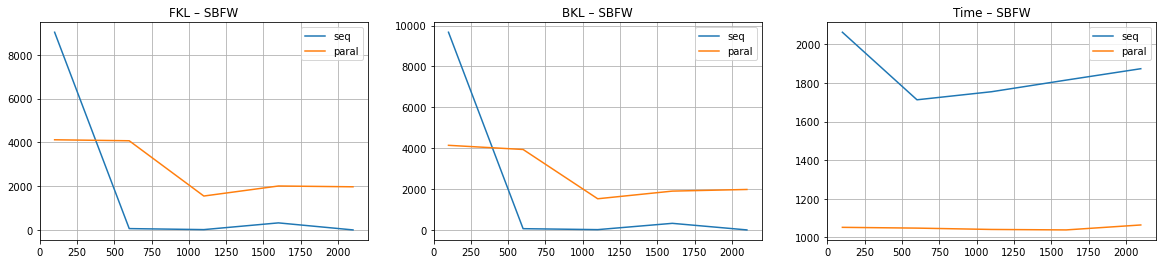

In [12]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))
ax[0].plot(coreset_sizes, fkl_s, label = 'seq')
ax[0].plot(coreset_sizes, fkl_p, label = 'paral')
ax[0].set_title('FKL – SBFW')
ax[0].grid()
ax[0].legend()

ax[1].plot(coreset_sizes, bkl_s, label = 'seq')
ax[1].plot(coreset_sizes, bkl_p, label = 'paral')
ax[1].set_title('BKL – SBFW')
ax[1].grid()
ax[1].legend()

ax[2].plot(coreset_sizes, time_s, label = 'seq')
ax[2].plot(coreset_sizes, time_p, label = 'paral')
ax[2].set_title('Time – SBFW')
ax[2].grid()
ax[2].legend()

## 1.3. Clustering based on Chebyshev norm

In [14]:
from sklearn.cluster import KMeans
from collections import Counter

start = time.time()

num_clusters = 8
R = 1e-5


# Cluster points with KMeans
km = KMeans(num_clusters)
point_labels = km.fit_predict(x)

# Calculate the number of points in each cluster
Gs = Counter(point_labels)
Gs = [Gs[key] for key in sorted(Gs.keys(), reverse=False)]

sense = np.zeros(N)

for i in range(N):
    denom_sum = 0
    for p in range(len(Gs)):
        Z = x[point_labels == p]
        Z = Z[Z != x[i]]
        rand_ind = np.random.randint(0, len(Z), 1)
        bar_Z_minus_n = np.mean(Z[rand_ind])
        denom_sum += Gs[p] * np.exp(R * np.linalg.norm(bar_Z_minus_n - x[i]))
        sense[i] = N / (1 + denom_sum)

estim_time = time.time() - start
print(estim_time)

11.255943059921265


In [15]:
coreset_sizes = np.arange(100, 2600, 500)

In [16]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

for i in coreset_sizes:
    
    ## Parallel
    
    start = time.time()
    # Step 1: distribute
    full_inds = distribute_based_on_sensitivities(sense.copy())
    
    # Step 2: run
    w = external_parallelization(SensitivityBasedFW, x, int(i // mp.cpu_count()), "2", 
                                 na, full_inds, None)
    time_p.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    sbfw = SensitivityBasedFW(x)
    w, I = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

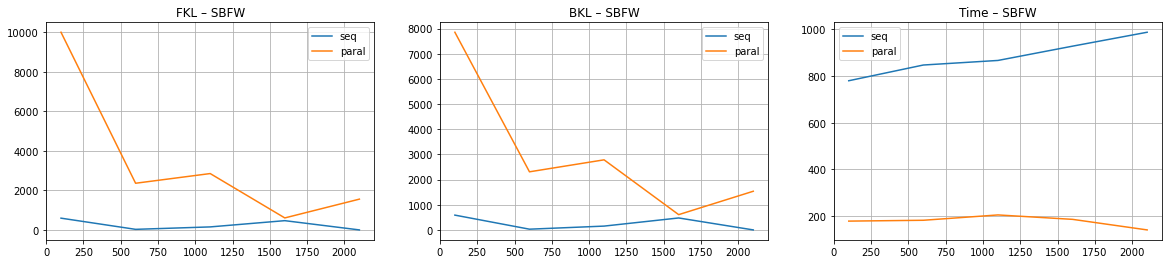

In [17]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))
ax[0].plot(coreset_sizes, fkl_s, label = 'seq')
ax[0].plot(coreset_sizes, fkl_p, label = 'paral')
ax[0].set_title('FKL – SBFW')
ax[0].grid()
ax[0].legend()

ax[1].plot(coreset_sizes, bkl_s, label = 'seq')
ax[1].plot(coreset_sizes, bkl_p, label = 'paral')
ax[1].set_title('BKL – SBFW')
ax[1].grid()
ax[1].legend()

ax[2].plot(coreset_sizes, time_s, label = 'seq')
ax[2].plot(coreset_sizes, time_p, label = 'paral')
ax[2].set_title('Time – SBFW')
ax[2].grid()
ax[2].legend()

In [ ]:
# THIS IS IT!!!!

## 1.4 Random distribution

In [7]:
from ebc.approximations import random_kitchen_sinks
start = time.time()
v = random_kitchen_sinks(x, None, 1, "Laplace", log_likelihood, 
                     np.ones(2 * d), 1000, norm = "2", MCMC_subs_size = 500)

likelihood_gram_matrix = v @ v.T

estim_time = time.time() - start
print(estim_time)

903.1662249565125


In [8]:
coreset_sizes = np.arange(100, 2600, 500)

In [9]:
def distribute_randomly(x):
    N = x.shape[0]
    
    probs = np.ones(N) / N
    
    # Calculate probabilities for distribution for each data point
    full_inds = []
    chunk_size = N // (mp.cpu_count() - 2)
    
    for i in range(mp.cpu_count() - 2):
        inds = np.random.choice(np.arange(N), chunk_size, replace = False, p = probs)
        probs[inds] = 0
        probs = probs / np.sum(probs)
        full_inds.append(inds.flatten().tolist())

    full_inds.append(np.arange(N)[probs.flatten() != 0].tolist())
    
    return full_inds

In [10]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

for i in coreset_sizes:
    
    ## Parallel
    
    start = time.time()
    # Step 1: distribute
    full_inds = distribute_randomly(x)
    
    # Step 2: run
    w = external_parallelization(SensitivityBasedFW, x, int(i // mp.cpu_count()), "2", 
                                 na, full_inds, likelihood_gram_matrix)
    time_p.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    sbfw = SensitivityBasedFW(x)
    w, I = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

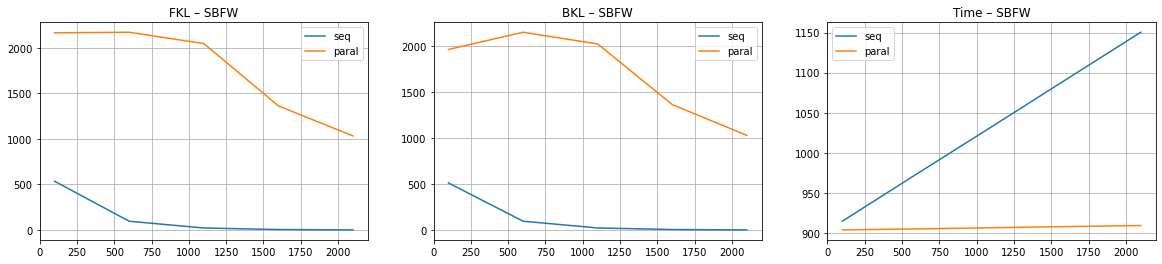

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))
ax[0].plot(coreset_sizes, fkl_s, label = 'seq')
ax[0].plot(coreset_sizes, fkl_p, label = 'paral')
ax[0].set_title('FKL – SBFW')
ax[0].grid()
ax[0].legend()

ax[1].plot(coreset_sizes, bkl_s, label = 'seq')
ax[1].plot(coreset_sizes, bkl_p, label = 'paral')
ax[1].set_title('BKL – SBFW')
ax[1].grid()
ax[1].legend()

ax[2].plot(coreset_sizes, time_s, label = 'seq')
ax[2].plot(coreset_sizes, time_p, label = 'paral')
ax[2].set_title('Time – SBFW')
ax[2].grid()
ax[2].legend()

## 1.5 Spectral clustering

In [41]:
import pandas as pd
#pd.DataFrame(v).to_csv('v.csv')
v = pd.read_csv('v.csv')
likelihood_gram_matrix = np.array(v @ v.T)
estim_time = 903.1662249565125

In [42]:
def distribute_sc(x):
    N = x.shape[0]
    full_inds = []
    
    from sklearn.cluster import SpectralClustering
    sc = SpectralClustering(mp.cpu_count() - 1)
    res = sc.fit_predict(likelihood_gram_matrix)
    
    for i in range(mp.cpu_count() - 1):
        full_inds.append((res == i).nonzero()[0].tolist())
    
    return full_inds

In [45]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

for i in coreset_sizes:
    
    ## Parallel
    
    start = time.time()
    # Step 1: distribute
    full_inds = distribute_sc(likelihood_gram_matrix)
    
    # Step 2: run
    w = external_parallelization(SensitivityBasedFW, x, int(i // mp.cpu_count()), "2", 
                                 na, full_inds, likelihood_gram_matrix)
    time_p.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    sbfw = SensitivityBasedFW(x)
    w, I = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_spectral.py:589: UserWarning

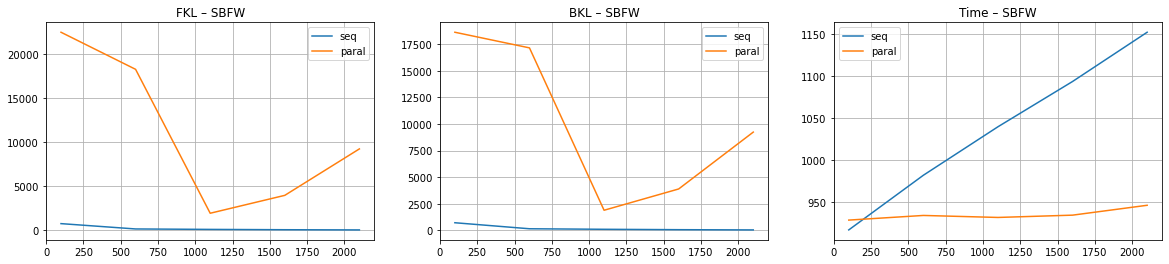

In [46]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))
ax[0].plot(coreset_sizes, fkl_s, label = 'seq')
ax[0].plot(coreset_sizes, fkl_p, label = 'paral')
ax[0].set_title('FKL – SBFW')
ax[0].grid()
ax[0].legend()

ax[1].plot(coreset_sizes, bkl_s, label = 'seq')
ax[1].plot(coreset_sizes, bkl_p, label = 'paral')
ax[1].set_title('BKL – SBFW')
ax[1].grid()
ax[1].legend()

ax[2].plot(coreset_sizes, time_s, label = 'seq')
ax[2].plot(coreset_sizes, time_p, label = 'paral')
ax[2].set_title('Time – SBFW')
ax[2].grid()
ax[2].legend()

## 1.6. Based on sensitivities (2)

In [7]:
import pandas as pd
v = pd.read_csv('v.csv')
likelihood_gram_matrix = np.array(v @ v.T)
estim_time = 903.1662249565125

In [8]:
def distribute_based_on_sensitivities2(sensitivities): # non-probs
    
    sens = sensitivities.copy()
    
    N = sens.shape[0]
    
    # Calculate probabilities for distribution for each data point
    full_inds = []
    chunk_size = N // (mp.cpu_count() - 2)
    
    for i in range(mp.cpu_count() - 2):
        inds = np.argsort(sens)[::-1][:chunk_size]
        sens[inds] = -1000
        full_inds.append(inds.flatten().tolist())

    full_inds.append(np.arange(N)[sens.flatten() != -1000].tolist())
    
    return full_inds

In [9]:
coreset_sizes = np.arange(100, 2600, 500)

In [10]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

for i in coreset_sizes:
    
    ## Parallel
    
    start = time.time()
    # Step 1: distribute
    sens = np.sqrt(np.diag(likelihood_gram_matrix))
    full_inds = distribute_based_on_sensitivities2(sens.copy())
    
    # Step 2: run
    w = external_parallelization(SensitivityBasedFW, x, int(i // mp.cpu_count()), "2", 
                                 na, full_inds, likelihood_gram_matrix)
    time_p.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    sbfw = SensitivityBasedFW(x)
    w, I = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

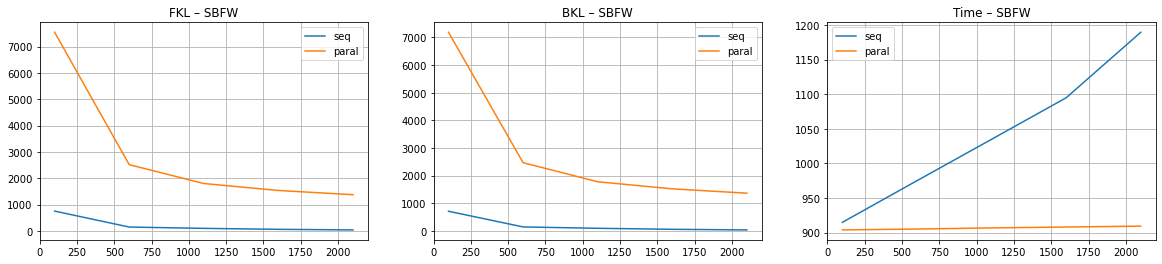

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))
ax[0].plot(coreset_sizes, fkl_s, label = 'seq')
ax[0].plot(coreset_sizes, fkl_p, label = 'paral')
ax[0].set_title('FKL – SBFW')
ax[0].grid()
ax[0].legend()

ax[1].plot(coreset_sizes, bkl_s, label = 'seq')
ax[1].plot(coreset_sizes, bkl_p, label = 'paral')
ax[1].set_title('BKL – SBFW')
ax[1].grid()
ax[1].legend()

ax[2].plot(coreset_sizes, time_s, label = 'seq')
ax[2].plot(coreset_sizes, time_p, label = 'paral')
ax[2].set_title('Time – SBFW')
ax[2].grid()
ax[2].legend()

## 1.6 Based on true lik matrix

In [12]:
from ebc.gaussian import fisher_norm_under_true_gaussian_posterior

likelihood_gram_matrix = fisher_norm_under_true_gaussian_posterior(x.T, x.T, mu_0, N)

In [15]:
coreset_sizes = np.arange(100, 2600, 500)

In [16]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

for i in coreset_sizes:
    
    ## Parallel
    
    start = time.time()
    # Step 1: distribute
    sens = np.sqrt(np.diag(likelihood_gram_matrix))
    full_inds = distribute_based_on_sensitivities(sens.copy())
    
    # Step 2: run
    w = external_parallelization(SensitivityBasedFW, x, int(i // mp.cpu_count()), "2", 
                                 na, full_inds, likelihood_gram_matrix)
    time_p.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    sbfw = SensitivityBasedFW(x)
    w, I = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

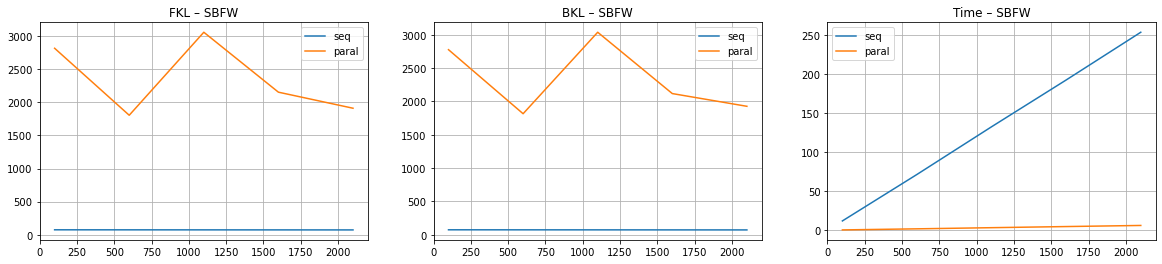

In [17]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))
ax[0].plot(coreset_sizes, fkl_s, label = 'seq')
ax[0].plot(coreset_sizes, fkl_p, label = 'paral')
ax[0].set_title('FKL – SBFW')
ax[0].grid()
ax[0].legend()

ax[1].plot(coreset_sizes, bkl_s, label = 'seq')
ax[1].plot(coreset_sizes, bkl_p, label = 'paral')
ax[1].set_title('BKL – SBFW')
ax[1].grid()
ax[1].legend()

ax[2].plot(coreset_sizes, time_s, label = 'seq')
ax[2].plot(coreset_sizes, time_p, label = 'paral')
ax[2].set_title('Time – SBFW')
ax[2].grid()
ax[2].legend()

## 1.7. Based on eigen

In [18]:
import pandas as pd
v = pd.read_csv('v.csv')
likelihood_gram_matrix = np.array(v @ v.T)
estim_time = 903.1662249565125

In [19]:
coreset_sizes = np.arange(100, 2600, 500)

In [ ]:
np.linalg.eig(likelihood_gram_matrix)

In [ ]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

for i in coreset_sizes:
    
    ## Parallel
    
    start = time.time()
    # Step 1: distribute
    sens = np.sqrt(np.diag(likelihood_gram_matrix))
    full_inds = distribute_based_on_sensitivities(sens.copy())
    
    # Step 2: run
    w = external_parallelization(SensitivityBasedFW, x, int(i // mp.cpu_count()), "2", 
                                 na, full_inds, likelihood_gram_matrix)
    time_p.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    sbfw = SensitivityBasedFW(x)
    w, I = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

## 1.8 Deterministic KMeans clustering (lgm = true Fisher from above)

In [7]:
from sklearn.cluster import KMeans
from collections import Counter

start = time.time()

num_clusters = 8
R = 1e-5


# Cluster points with KMeans
km = KMeans(num_clusters)
point_labels = km.fit_predict(x)

# Calculate the number of points in each cluster
Gs = Counter(point_labels)
Gs = [Gs[key] for key in sorted(Gs.keys(), reverse=False)]

sense = np.zeros(N)

for i in range(N):
    denom_sum = 0
    for p in range(len(Gs)):
        Z = x[point_labels == p]
        Z = Z[Z != x[i]]
        rand_ind = np.random.randint(0, len(Z), 1)
        bar_Z_minus_n = np.mean(Z[rand_ind])
        denom_sum += Gs[p] * np.exp(R * np.linalg.norm(bar_Z_minus_n - x[i]))
        sense[i] = N / (1 + denom_sum)

estim_time = time.time() - start
print(estim_time)

11.184273958206177


In [8]:
coreset_sizes = np.arange(100, 2600, 500)

In [14]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

for i in coreset_sizes:
    
    ## Parallel
    
    start = time.time()
    # Step 1: distribute
    #sens = np.sqrt(np.diag(likelihood_gram_matrix))
    full_inds = distribute_based_on_sensitivities2(sense.copy())
    
    # Step 2: run
    w = external_parallelization(SensitivityBasedFW, x, int(i // mp.cpu_count()), "2", 
                                 na, full_inds, likelihood_gram_matrix)
    time_p.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    sbfw = SensitivityBasedFW(x)
    w, I = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

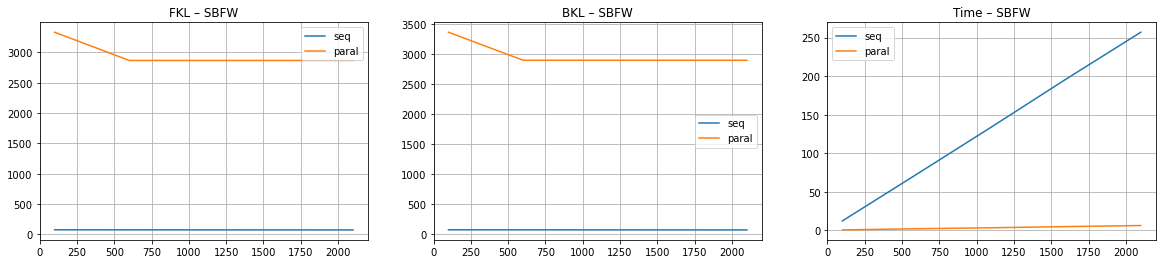

In [15]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))
ax[0].plot(coreset_sizes, fkl_s, label = 'seq')
ax[0].plot(coreset_sizes, fkl_p, label = 'paral')
ax[0].set_title('FKL – SBFW')
ax[0].grid()
ax[0].legend()

ax[1].plot(coreset_sizes, bkl_s, label = 'seq')
ax[1].plot(coreset_sizes, bkl_p, label = 'paral')
ax[1].set_title('BKL – SBFW')
ax[1].grid()
ax[1].legend()

ax[2].plot(coreset_sizes, time_s, label = 'seq')
ax[2].plot(coreset_sizes, time_p, label = 'paral')
ax[2].set_title('Time – SBFW')
ax[2].grid()
ax[2].legend()

## 1.9 All parallel

In [18]:
import pandas as pd
v = pd.read_csv('v.csv')
likelihood_gram_matrix = np.array(v @ v.T)
estim_time = 903.1662249565125

In [19]:
coreset_sizes = np.arange(100, 2600, 500)

In [20]:
def external_parallelization3(alg, x, k, norm, na, distributed_indices, likelihood_gram_matrix):
    pool = get_context("fork").Pool(mp.cpu_count() - 1)
    
    if likelihood_gram_matrix is None:
        output = [pool.apply(apply_algorithm, args = [alg, 
                                                      x[ind, :],
                                                      k, 
                                                      norm, 
                                                      na,
                                                      None]) for ind in distributed_indices]
    else:
        output = [pool.apply(apply_algorithm, args = [alg, 
                                                      x[ind, :],
                                                      k, 
                                                      norm, 
                                                      na,
                                                      likelihood_gram_matrix[np.ix_(ind, ind)]]) for ind in distributed_indices]
    
    
    pool.close()
    w = np.concatenate(output).reshape(N, -1)
    w = np.mean(w, axis = 1).reshape(-1, 1)
    
    return w

In [21]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

for i in coreset_sizes:
    
    ## Parallel
    
    start = time.time()
    # Step 1: distribute
    #sens = np.sqrt(np.diag(likelihood_gram_matrix))
    full_inds = [np.arange(N).tolist()] * (mp.cpu_count() - 1)
    
    # Step 2: run
    w = external_parallelization3(SensitivityBasedFW, x, int(i // mp.cpu_count()), "2", 
                                 na, full_inds, likelihood_gram_matrix)
    time_p.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    sbfw = SensitivityBasedFW(x)
    w, I = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

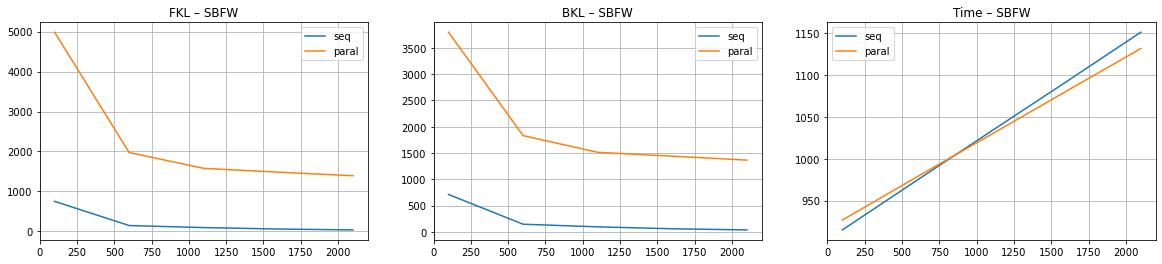

In [22]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))
ax[0].plot(coreset_sizes, fkl_s, label = 'seq')
ax[0].plot(coreset_sizes, fkl_p, label = 'paral')
ax[0].set_title('FKL – SBFW')
ax[0].grid()
ax[0].legend()

ax[1].plot(coreset_sizes, bkl_s, label = 'seq')
ax[1].plot(coreset_sizes, bkl_p, label = 'paral')
ax[1].set_title('BKL – SBFW')
ax[1].grid()
ax[1].legend()

ax[2].plot(coreset_sizes, time_s, label = 'seq')
ax[2].plot(coreset_sizes, time_p, label = 'paral')
ax[2].set_title('Time – SBFW')
ax[2].grid()
ax[2].legend()

In [23]:
def external_parallelization3(alg, x, k, norm, na, distributed_indices, likelihood_gram_matrix):
    pool = get_context("fork").Pool(mp.cpu_count() - 1)
    
    if likelihood_gram_matrix is None:
        output = [pool.apply(apply_algorithm, args = [alg, 
                                                      x[ind, :],
                                                      k, 
                                                      norm, 
                                                      na,
                                                      None]) for ind in distributed_indices]
    else:
        output = [pool.apply(apply_algorithm, args = [alg, 
                                                      x[ind, :],
                                                      k, 
                                                      norm, 
                                                      na,
                                                      likelihood_gram_matrix[np.ix_(ind, ind)]]) for ind in distributed_indices]
    
    
    pool.close()
    w = np.concatenate(output).reshape(N, -1)
    w = np.max(w, axis = 1).reshape(-1, 1)
    
    return w

In [24]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

for i in coreset_sizes:
    
    ## Parallel
    
    start = time.time()
    # Step 1: distribute
    #sens = np.sqrt(np.diag(likelihood_gram_matrix))
    full_inds = [np.arange(N).tolist()] * (mp.cpu_count() - 1)
    
    # Step 2: run
    w = external_parallelization3(SensitivityBasedFW, x, int(i // mp.cpu_count()), "2", 
                                 na, full_inds, likelihood_gram_matrix)
    time_p.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    sbfw = SensitivityBasedFW(x)
    w, I = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

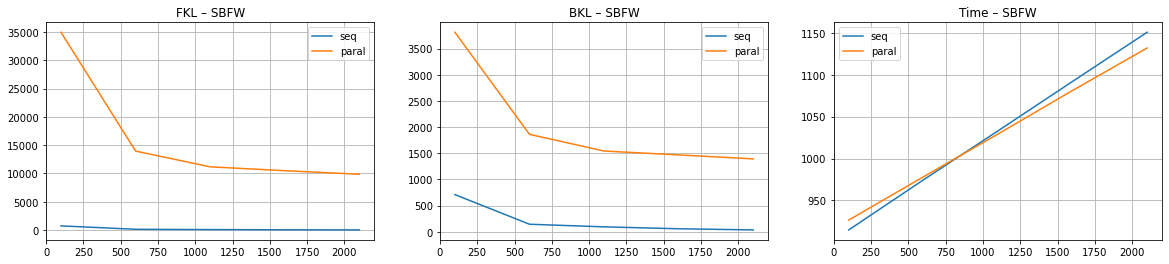

In [25]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))
ax[0].plot(coreset_sizes, fkl_s, label = 'seq')
ax[0].plot(coreset_sizes, fkl_p, label = 'paral')
ax[0].set_title('FKL – SBFW')
ax[0].grid()
ax[0].legend()

ax[1].plot(coreset_sizes, bkl_s, label = 'seq')
ax[1].plot(coreset_sizes, bkl_p, label = 'paral')
ax[1].set_title('BKL – SBFW')
ax[1].grid()
ax[1].legend()

ax[2].plot(coreset_sizes, time_s, label = 'seq')
ax[2].plot(coreset_sizes, time_p, label = 'paral')
ax[2].set_title('Time – SBFW')
ax[2].grid()
ax[2].legend()

In [26]:
def external_parallelization3(alg, x, k, norm, na, distributed_indices, likelihood_gram_matrix):
    pool = get_context("fork").Pool(mp.cpu_count() - 1)
    
    if likelihood_gram_matrix is None:
        output = [pool.apply(apply_algorithm, args = [alg, 
                                                      x[ind, :],
                                                      k, 
                                                      norm, 
                                                      na,
                                                      None]) for ind in distributed_indices]
    else:
        output = [pool.apply(apply_algorithm, args = [alg, 
                                                      x[ind, :],
                                                      k, 
                                                      norm, 
                                                      na,
                                                      likelihood_gram_matrix[np.ix_(ind, ind)]]) for ind in distributed_indices]
    
    
    pool.close()
    w = np.concatenate(output).reshape(N, -1)
    w = np.median(w, axis = 1).reshape(-1, 1)
    
    return w

In [27]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

for i in coreset_sizes:
    
    ## Parallel
    
    start = time.time()
    # Step 1: distribute
    #sens = np.sqrt(np.diag(likelihood_gram_matrix))
    full_inds = [np.arange(N).tolist()] * (mp.cpu_count() - 1)
    
    # Step 2: run
    w = external_parallelization3(SensitivityBasedFW, x, int(i // mp.cpu_count()), "2", 
                                 na, full_inds, likelihood_gram_matrix)
    time_p.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    sbfw = SensitivityBasedFW(x)
    w, I = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

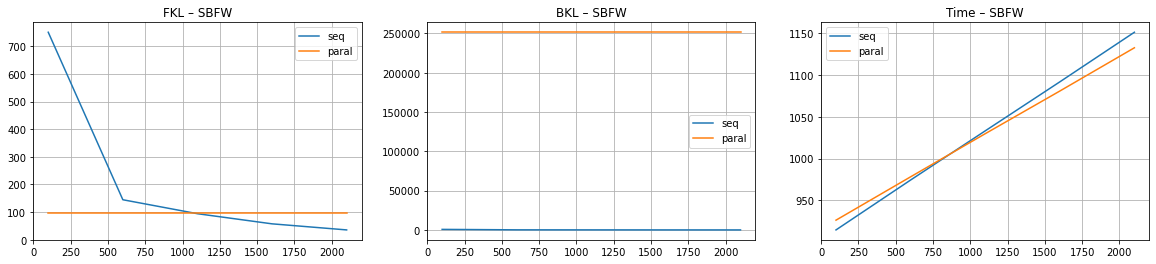

In [28]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))
ax[0].plot(coreset_sizes, fkl_s, label = 'seq')
ax[0].plot(coreset_sizes, fkl_p, label = 'paral')
ax[0].set_title('FKL – SBFW')
ax[0].grid()
ax[0].legend()

ax[1].plot(coreset_sizes, bkl_s, label = 'seq')
ax[1].plot(coreset_sizes, bkl_p, label = 'paral')
ax[1].set_title('BKL – SBFW')
ax[1].grid()
ax[1].legend()

ax[2].plot(coreset_sizes, time_s, label = 'seq')
ax[2].plot(coreset_sizes, time_p, label = 'paral')
ax[2].set_title('Time – SBFW')
ax[2].grid()
ax[2].legend()

In [41]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

for i in coreset_sizes:
    
    ## Parallel
    
    start = time.time()
    # Step 1: distribute
    #sens = np.sqrt(np.diag(likelihood_gram_matrix))
    full_inds = [np.arange(N).tolist()] * (mp.cpu_count() - 1)
    
    # Step 2: run
    w = external_parallelization3(SensitivityBasedFW, x, int(i // mp.cpu_count()), "2", 
                                 na, full_inds, likelihood_gram_matrix)
    time_p.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    sbfw = SensitivityBasedFW(x)
    w, I = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

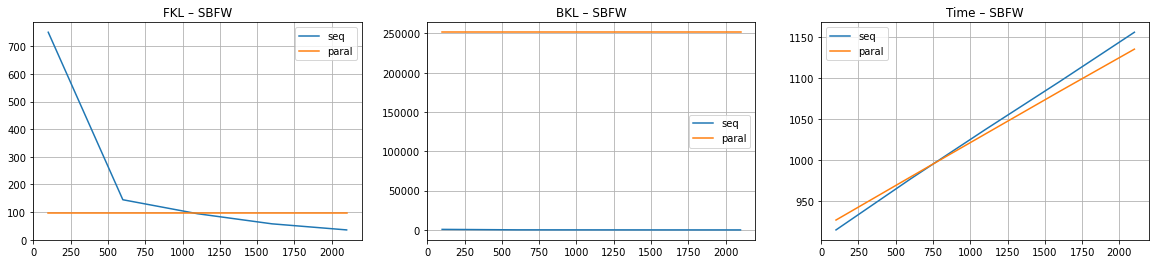

In [42]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))
ax[0].plot(coreset_sizes, fkl_s, label = 'seq')
ax[0].plot(coreset_sizes, fkl_p, label = 'paral')
ax[0].set_title('FKL – SBFW')
ax[0].grid()
ax[0].legend()

ax[1].plot(coreset_sizes, bkl_s, label = 'seq')
ax[1].plot(coreset_sizes, bkl_p, label = 'paral')
ax[1].set_title('BKL – SBFW')
ax[1].grid()
ax[1].legend()

ax[2].plot(coreset_sizes, time_s, label = 'seq')
ax[2].plot(coreset_sizes, time_p, label = 'paral')
ax[2].set_title('Time – SBFW')
ax[2].grid()
ax[2].legend()

In [43]:
fkl_p

[97.27147392237904,
 97.27147392237904,
 97.27147392237904,
 97.27147392237904,
 97.27147392237904]

In [45]:
bkl_p

[251583.76519272174,
 251583.76519272174,
 251583.76519272174,
 251583.76519272174,
 251583.76519272174]

## 1.10 IS then FW

In [14]:
import pandas as pd
v = pd.read_csv('v.csv')
likelihood_gram_matrix = np.array(v @ v.T)
estim_time = 903.1662249565125

In [15]:
coreset_sizes = np.arange(100, 2600, 500)

In [16]:
from ebc.sequential.non_iterative import SensitivityBasedIS

In [17]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

for i in coreset_sizes:
    
    ## Parallel
    
    start = time.time()
    
    sbis = SensitivityBasedIS(x)
    w, I = sbis.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
    
    x_new = x[I, :]
    lgm_new = likelihood_gram_matrix[np.ix_(I, I)]
    sbfw = SensitivityBasedFW(x_new)
    w_fw, I_fw = sbfw.run(k = i, likelihood_gram_matrix = lgm_new, norm = "2", norm_attributes = na)
    w[I] = w_fw
    time_p.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    sbfw = SensitivityBasedFW(x)
    w, I = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

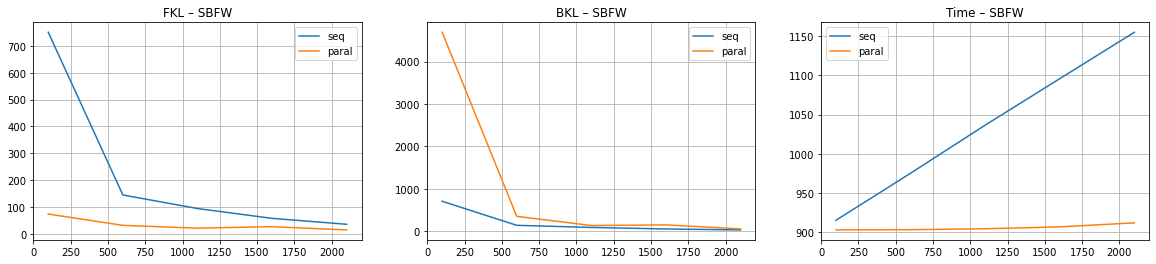

In [18]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))
ax[0].plot(coreset_sizes, fkl_s, label = 'seq')
ax[0].plot(coreset_sizes, fkl_p, label = 'paral')
ax[0].set_title('FKL – SBFW')
ax[0].grid()
ax[0].legend()

ax[1].plot(coreset_sizes, bkl_s, label = 'seq')
ax[1].plot(coreset_sizes, bkl_p, label = 'paral')
ax[1].set_title('BKL – SBFW')
ax[1].grid()
ax[1].legend()

ax[2].plot(coreset_sizes, time_s, label = 'seq')
ax[2].plot(coreset_sizes, time_p, label = 'paral')
ax[2].set_title('Time – SBFW')
ax[2].grid()
ax[2].legend()

## 1.11 IS + FW

In [7]:
import pandas as pd
v = pd.read_csv('v.csv')
likelihood_gram_matrix = np.array(v @ v.T)
estim_time = 903.1662249565125

In [8]:
coreset_sizes = np.arange(100, 2600, 500)

In [9]:
from ebc.sequential.non_iterative import SensitivityBasedIS

In [10]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

for i in coreset_sizes:
    
    ## Parallel
    
    start = time.time()
    
    sbis = SensitivityBasedIS(x)
    w, I = sbis.run(k = 2 * i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
    
    x_new = x[I, :]
    lgm_new = likelihood_gram_matrix[np.ix_(I, I)]
    sbfw = SensitivityBasedFW(x_new)
    w_fw, I_fw = sbfw.run(k = i, likelihood_gram_matrix = lgm_new, norm = "2", norm_attributes = na)
    w[I] = w_fw
    time_p.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    sbfw = SensitivityBasedFW(x)
    w, I = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

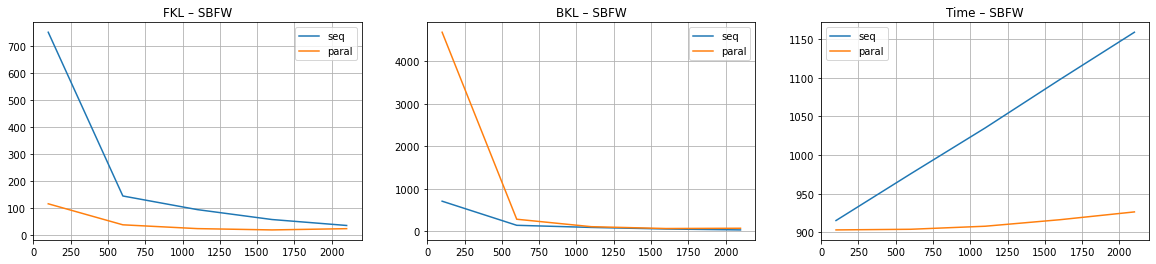

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))
ax[0].plot(coreset_sizes, fkl_s, label = 'seq')
ax[0].plot(coreset_sizes, fkl_p, label = 'paral')
ax[0].set_title('FKL – SBFW')
ax[0].grid()
ax[0].legend()

ax[1].plot(coreset_sizes, bkl_s, label = 'seq')
ax[1].plot(coreset_sizes, bkl_p, label = 'paral')
ax[1].set_title('BKL – SBFW')
ax[1].grid()
ax[1].legend()

ax[2].plot(coreset_sizes, time_s, label = 'seq')
ax[2].plot(coreset_sizes, time_p, label = 'paral')
ax[2].set_title('Time – SBFW')
ax[2].grid()
ax[2].legend()

## 1.12 IS + SVI

In [8]:
import pandas as pd
v = pd.read_csv('v.csv')
likelihood_gram_matrix = np.array(v @ v.T)
estim_time = 903.1662249565125

In [9]:
coreset_sizes = np.arange(100, 2600, 500)

In [10]:
from ebc.sequential.non_iterative import SensitivityBasedIS

In [11]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

for i in coreset_sizes:
    
    ## Parallel
    
    start = time.time()
    
    sbis = SensitivityBasedIS(x)
    w, I = sbis.run(k = 2 * i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
    
    x_new = x[I, :]
    lgm_new = likelihood_gram_matrix[np.ix_(I, I)]
    svi = SparseVI(x_new)
    w_svi, I_svi = svi.run(k = i, likelihood_gram_matrix = lgm_new, 
                         norm_attributes = na, T = 400, gamma_func = lambda x : 1e-4 / x)
    w[I] = w_svi
    time_p.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    svi = SparseVI(x)
    w, I = svi.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, 
                   norm_attributes = na, T = 400, gamma_func = lambda x : 1e-4 / x)
    time_s.append(time.time() - start + estim_time)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

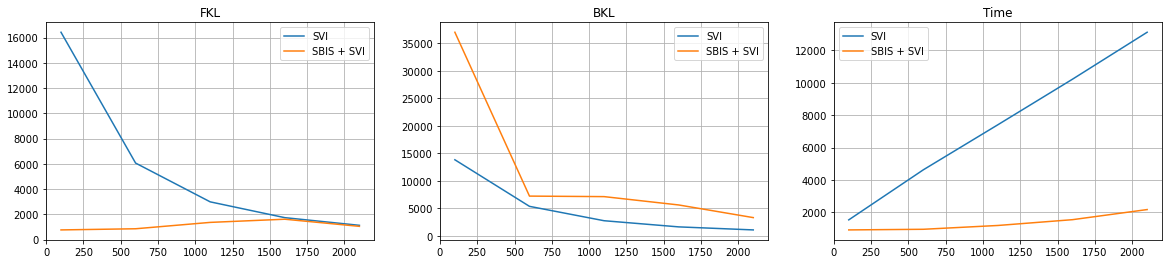

In [13]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))
ax[0].plot(coreset_sizes, fkl_s, label = 'SVI')
ax[0].plot(coreset_sizes, fkl_p, label = 'SBIS + SVI')
ax[0].set_title('FKL')
ax[0].grid()
ax[0].legend()

ax[1].plot(coreset_sizes, bkl_s, label = 'SVI')
ax[1].plot(coreset_sizes, bkl_p, label = 'SBIS + SVI')
ax[1].set_title('BKL')
ax[1].grid()
ax[1].legend()

ax[2].plot(coreset_sizes, time_s, label = 'SVI')
ax[2].plot(coreset_sizes, time_p, label = 'SBIS + SVI')
ax[2].set_title('Time')
ax[2].grid()
ax[2].legend()

TypeError: unsupported operand type(s) for /: 'list' and 'int'

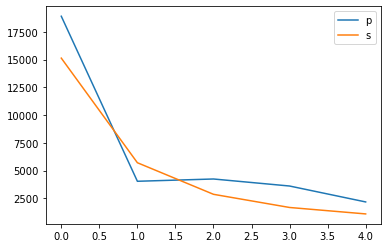

In [17]:
plt.plot((np.array(fkl_p) + np.array(bkl_p)) / 2, label = 'p')
plt.plot((np.array(fkl_s) + np.array(bkl_s)) / 2, label = 's')
plt.legend()

In [18]:
np.mean(((np.array(fkl_p) + np.array(bkl_p)) / 2 - (np.array(fkl_s) + np.array(bkl_s)) / 2) ** 2)

4760272.264187976

## Multistep

In [7]:
coreset_sizes = np.arange(100, 2600, 500)

In [8]:
def distribute_randomly(x):
    N = x.shape[0]
    
    probs = np.ones(N) / N
    
    # Calculate probabilities for distribution for each data point
    full_inds = []
    chunk_size = N // (mp.cpu_count() - 2)
    
    for i in range(mp.cpu_count() - 2):
        inds = np.random.choice(np.arange(N), chunk_size, replace = False, p = probs)
        probs[inds] = 0
        probs = probs / np.sum(probs)
        full_inds.append(inds.flatten().tolist())

    full_inds.append(np.arange(N)[probs.flatten() != 0].tolist())
    
    return full_inds

In [9]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

for i in coreset_sizes:
    
    print(i)
    
    ## Parallel
    
    start = time.time()
    
    # Step 1: distribute
    #sens = np.sqrt(np.diag(likelihood_gram_matrix))
    #full_inds = distribute_based_on_sensitivities(sens.copy())
    full_inds = distribute_randomly(x)
    
    # Step 2: run IS
    w_is = external_parallelization(SensitivityBasedIS, x, 2 * i, "2", 
                                 na, full_inds, None)
    
    # Step 3: get smaller dataset
    x_new = x[w_is.flatten() != 0]
    x_new = x_new.copy()
    
    # Step 4: run FW on it
    sbfw = SensitivityBasedFW(x_new)
    w_fw, I_fw = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)
    
    w_is[w_is.flatten() != 0] = w_fw
    w = w_is.copy()
    
    time_p.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    sbfw = SensitivityBasedFW(x)
    w, I = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

100
600
1100
1600
2100


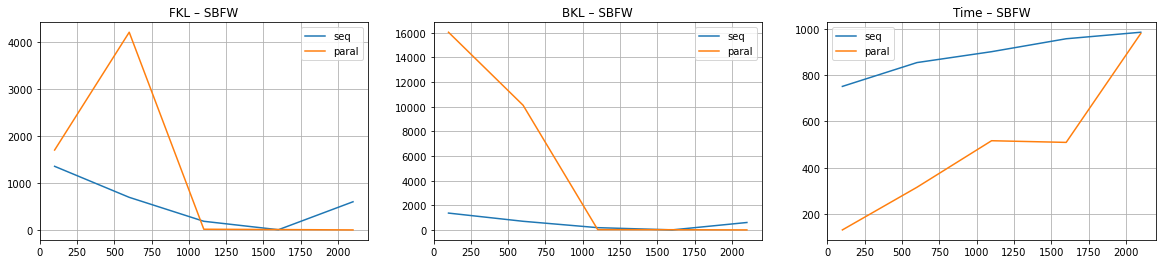

In [10]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))
ax[0].plot(coreset_sizes, fkl_s, label = 'seq')
ax[0].plot(coreset_sizes, fkl_p, label = 'paral')
ax[0].set_title('FKL – SBFW')
ax[0].grid()
ax[0].legend()

ax[1].plot(coreset_sizes, bkl_s, label = 'seq')
ax[1].plot(coreset_sizes, bkl_p, label = 'paral')
ax[1].set_title('BKL – SBFW')
ax[1].grid()
ax[1].legend()

ax[2].plot(coreset_sizes, time_s, label = 'seq')
ax[2].plot(coreset_sizes, time_p, label = 'paral')
ax[2].set_title('Time – SBFW')
ax[2].grid()
ax[2].legend()

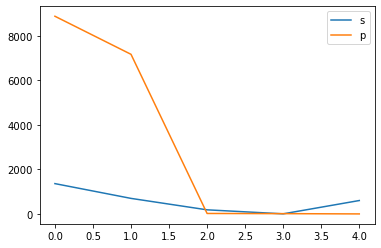

In [11]:
plt.plot((np.array(fkl_s) + np.array(bkl_s)) / 2, label = 's')
plt.plot((np.array(fkl_p) + np.array(bkl_p)) / 2, label = 'p')
plt.legend()

In [12]:
fkl_s

[1358.7627025962242,
 698.7702333659118,
 188.83221054676486,
 9.451118338808126,
 604.5531175963787]

In [13]:
bkl_s

[1371.7113822540384,
 706.0747964324978,
 189.61025936071604,
 9.471567494471268,
 608.3104469236704]

In [14]:
fkl_p

[1705.268229334411,
 4212.2576667675185,
 19.52964061694327,
 13.1443426430676,
 5.299003823904721]

In [15]:
bkl_p

[16042.724133330164,
 10119.812624700753,
 32.551284587296436,
 23.25848519951723,
 6.407410180981928]

In [16]:
time_s

[751.3763339519501,
 854.280886888504,
 901.3181700706482,
 957.1397876739502,
 985.2748160362244]

In [17]:
time_p

[131.54858016967773,
 315.84164690971375,
 516.7497551441193,
 509.5423696041107,
 979.9527599811554]

---

In [7]:
coreset_sizes = np.arange(100, 260, 50)

In [8]:
def distribute_randomly(x):
    N = x.shape[0]
    
    probs = np.ones(N) / N
    
    # Calculate probabilities for distribution for each data point
    full_inds = []
    chunk_size = N // (mp.cpu_count() - 2)
    
    for i in range(mp.cpu_count() - 2):
        inds = np.random.choice(np.arange(N), chunk_size, replace = False, p = probs)
        probs[inds] = 0
        probs = probs / np.sum(probs)
        full_inds.append(inds.flatten().tolist())

    full_inds.append(np.arange(N)[probs.flatten() != 0].tolist())
    
    return full_inds

In [9]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

for i in coreset_sizes:
    
    print(i)
    
    ## Parallel
    
    start = time.time()
    
    # Step 1: distribute
    #sens = np.sqrt(np.diag(likelihood_gram_matrix))
    #full_inds = distribute_based_on_sensitivities(sens.copy())
    full_inds = distribute_randomly(x)
    
    # Step 2: run IS
    w_is = external_parallelization(SensitivityBasedIS, x, 2 * i, "2", 
                                 na, full_inds, None)
    
    # Step 3: get smaller dataset
    x_new = x[w_is.flatten() != 0]
    x_new = x_new.copy()
    
    # Step 4: run FW on it
    sbfw = SensitivityBasedFW(x_new)
    w_fw, I_fw = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)
    
    w_is[w_is.flatten() != 0] = w_fw
    w = w_is.copy()
    
    time_p.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    sbfw = SensitivityBasedFW(x)
    w, I = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

100


ValueError: Cannot take a larger sample than population when 'replace=False'

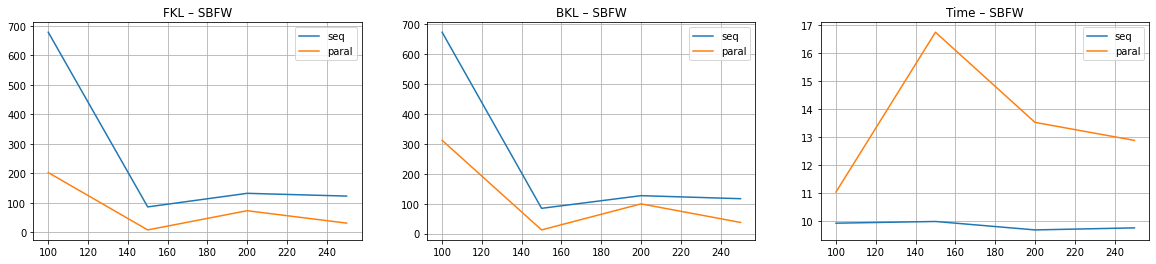

In [10]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))
ax[0].plot(coreset_sizes, fkl_s, label = 'seq')
ax[0].plot(coreset_sizes, fkl_p, label = 'paral')
ax[0].set_title('FKL – SBFW')
ax[0].grid()
ax[0].legend()

ax[1].plot(coreset_sizes, bkl_s, label = 'seq')
ax[1].plot(coreset_sizes, bkl_p, label = 'paral')
ax[1].set_title('BKL – SBFW')
ax[1].grid()
ax[1].legend()

ax[2].plot(coreset_sizes, time_s, label = 'seq')
ax[2].plot(coreset_sizes, time_p, label = 'paral')
ax[2].set_title('Time – SBFW')
ax[2].grid()
ax[2].legend()

---

In [7]:
coreset_sizes = np.arange(100, 2600, 500)

In [8]:
def distribute_randomly(x):
    N = x.shape[0]
    
    probs = np.ones(N) / N
    
    # Calculate probabilities for distribution for each data point
    full_inds = []
    chunk_size = N // (mp.cpu_count() - 2)
    
    for i in range(mp.cpu_count() - 2):
        inds = np.random.choice(np.arange(N), chunk_size, replace = False, p = probs)
        probs[inds] = 0
        probs = probs / np.sum(probs)
        full_inds.append(inds.flatten().tolist())

    full_inds.append(np.arange(N)[probs.flatten() != 0].tolist())
    
    return full_inds

In [9]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

for i in coreset_sizes:
    
    print(i)
    
    ## Parallel
    
    start = time.time()
    
    # Step 1: distribute
    #sens = np.sqrt(np.diag(likelihood_gram_matrix))
    #full_inds = distribute_based_on_sensitivities(sens.copy())
    full_inds = distribute_randomly(x)
    
    # Step 2: run IS
    w_is = external_parallelization(SensitivityBasedIS, x, 2 * i, "2", 
                                 na, full_inds, None)
    
    # Step 3: get smaller dataset
    x_new = x[w_is.flatten() != 0]
    x_new = x_new.copy()
    
    # Step 4: run FW on it
    iht = IHT(x_new)
    w_i, I_i = iht.run(k = i, likelihood_vectors = None, norm = "2", norm_attributes = na)
    
    w_is[w_is.flatten() != 0] = w_i
    w = w_is.copy()
    
    time_p.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    iht = IHT(x)
    w, I = iht.run(k = i, likelihood_vectors = None, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

100
600
1100
1600
2100


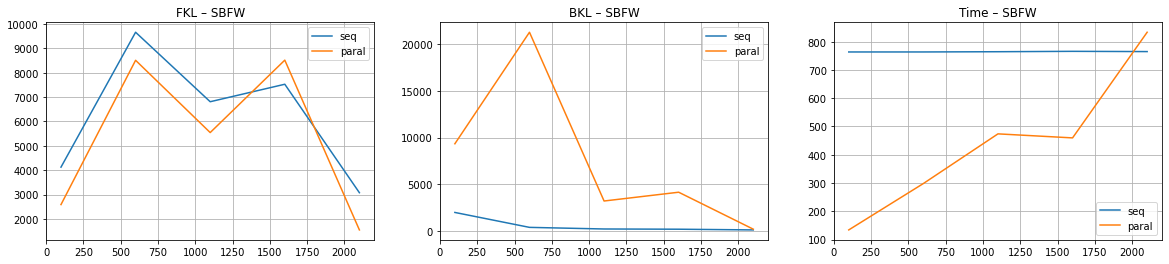

In [12]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))
ax[0].plot(coreset_sizes, fkl_s, label = 'seq')
ax[0].plot(coreset_sizes, fkl_p, label = 'paral')
ax[0].set_title('FKL – SBFW')
ax[0].grid()
ax[0].legend()

ax[1].plot(coreset_sizes, bkl_s, label = 'seq')
ax[1].plot(coreset_sizes, bkl_p, label = 'paral')
ax[1].set_title('BKL – SBFW')
ax[1].grid()
ax[1].legend()

ax[2].plot(coreset_sizes, time_s, label = 'seq')
ax[2].plot(coreset_sizes, time_p, label = 'paral')
ax[2].set_title('Time – SBFW')
ax[2].grid()
ax[2].legend()

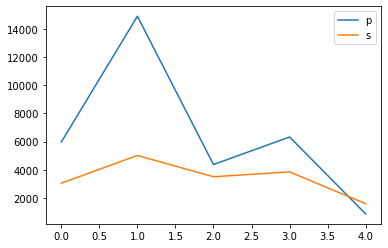

In [13]:
plt.plot((np.array(fkl_p) + np.array(bkl_p)) / 2, label = 'p')
plt.plot((np.array(fkl_s) + np.array(bkl_s)) / 2, label = 's')
plt.legend()

In [16]:
fkl_s

[4125.314998119884,
 9662.225018606894,
 6810.207197388119,
 7527.626862104357,
 3075.951294401209]

In [17]:
fkl_p

[2588.3634214171725,
 8510.63915490089,
 5544.267652419155,
 8517.214745717018,
 1548.4418064566478]

In [18]:
bkl_s

[1974.9216631738745,
 373.86985789219005,
 200.0379542510018,
 175.53550480504228,
 100.30634139374916]

In [19]:
bkl_p

[9345.136227750469,
 21310.451570922287,
 3202.5355992492446,
 4145.183976675821,
 179.75798406860122]

In [20]:
time_s

[763.5831978321075,
 763.6279890537262,
 764.4717490673065,
 765.8268229961395,
 764.9309170246124]

In [21]:
time_p

[134.0679647922516,
 298.17367029190063,
 473.85752511024475,
 459.6211009025574,
 833.3635447025299]